# Exploring San Francisco International Airport Landings Statistics Data

For detailed information about the dataset, please visit [their official website](https://data.sfgov.org/Transportation/Air-Traffic-Landings-Statistics/fpux-q53t).

### Downloading the data file

First we send a HTTP GET request and fetch the data

In [1]:
import requests

download_file = requests.get('https://data.sfgov.org/api/views/fpux-q53t/rows.csv?accessType=DOWNLOAD')
if download_file.status_code != 200:
    print('Error while fetching the data')
else:
    print('Data successfully received')

Data successfully received


Let's look at the location where this data will be saved.

In [2]:
import os
import sys

filename = os.path.join(os.path.dirname(sys.argv[0]), download_file.headers['content-disposition'].split(';')[-1].strip().split('=')[-1])
print('Data will be saved in: ' + filename)

Data will be saved in: c:\users\sudip.a.banerjee\pycharmprojects\learning\venv\lib\site-packages\Air_Traffic_Landings_Statistics.csv


Now we save the data in a CSV file

In [3]:
op_file = open(filename, 'wb')
op_file.write(download_file.content)
op_file.close()

Let's see the top 5 rows of the file

In [4]:
file = open(filename, 'r')
for _ in range(5):
    print(file.readline())
file.close()

Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight

200507,ABX Air,GB,ABX Air,GB,Domestic,US,Freighter,Narrow Body,McDonnell Douglas,DC-9,30,40,4066000

200507,ABX Air,GB,ABX Air,GB,Domestic,US,Freighter,Narrow Body,McDonnell Douglas,DC-9,41,1,102000

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,2,396000

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,167,37408000



### Reading the file in Spark

We'll be using Spark's DataFrame API. So let's initiate a SparkSession

We're enabling the eager execution for Spark. This is enabled to get a good view of the DataFrame in the Notebook, which isn't possible after we call an action.

> NOTE: This isn't advised in case of production environment.

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('SF_Landing_Statistics').config('spark.sql.repl.eagerEval.enabled', 'True').getOrCreate()

Reading the CSV file

In [6]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
                StructField('ActivityPeriod', IntegerType(), True)
                , StructField('OperatingAirline', StringType(), True)
                , StructField('OperatingAirlineIATACode', StringType(), True)
                , StructField('PublishedAirline', StringType(), True)
                , StructField('PublishedAirlineIATACode', StringType(), True)
                , StructField('GEOSummary', StringType(), True)
                , StructField('GEORegion', StringType(), True)
                , StructField('LandingAircraftType', StringType(), True)
                , StructField('AircraftBodyType', StringType(), True)
                , StructField('AircraftManufacturer', StringType(), True)
                , StructField('AircraftModel', StringType(), True)
                , StructField('AircraftVersion', StringType(), True)
                , StructField('LandingCount', IntegerType(), True)
                , StructField('TotalLandedWeight', IntegerType(), True)
            ])
input_data = spark.read.csv(filename, header=True, sep=',', schema=schema)

Let's see the top 5 rows of the DataFrame

In [7]:
input_data.limit(5)

ActivityPeriod,OperatingAirline,OperatingAirlineIATACode,PublishedAirline,PublishedAirlineIATACode,GEOSummary,GEORegion,LandingAircraftType,AircraftBodyType,AircraftManufacturer,AircraftModel,AircraftVersion,LandingCount,TotalLandedWeight
200507,ABX Air,GB,ABX Air,GB,Domestic,US,Freighter,Narrow Body,McDonnell Douglas,DC-9,30,40,4066000
200507,ABX Air,GB,ABX Air,GB,Domestic,US,Freighter,Narrow Body,McDonnell Douglas,DC-9,41,1,102000
200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,2,396000
200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,167,37408000
200507,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Wide Body,Boeing,767,333,1,320000


In [8]:
from pyspark.sql.functions import sum

input_data.select('LandingAircraftType', 'OperatingAirline', 'LandingCount')\
        .groupBy('LandingAircraftType', 'OperatingAirline')\
        .agg(sum('LandingCount').alias('TotalLandingCount'))\
        .orderBy('TotalLandingCount', ascending=False)\
        .limit(5)

LandingAircraftType,OperatingAirline,TotalLandingCount
Passenger,SkyWest Airlines,615024
Passenger,United Airlines,455200
Passenger,United Airlines -...,372934
Passenger,Southwest Airlines,178115
Passenger,American Airlines,173105


In [9]:
input_data.select('LandingAircraftType', 'PublishedAirline', 'LandingCount')\
        .groupBy('LandingAircraftType', 'PublishedAirline')\
        .agg(sum('LandingCount').alias('TotalLandingCount'))\
        .orderBy('TotalLandingCount', ascending=False)\
        .limit(5)

LandingAircraftType,PublishedAirline,TotalLandingCount
Passenger,United Airlines -...,718455
Passenger,United Airlines,691552
Passenger,American Airlines,193348
Passenger,Delta Air Lines,181165
Passenger,Southwest Airlines,178115


In [10]:
input_data.select('GEOSummary', 'GEORegion', 'LandingCount')\
        .groupBy('GEOSummary', 'GEORegion')\
        .agg(sum('LandingCount').alias('TotalLandingCount'))\
        .orderBy('TotalLandingCount', ascending=False)\
        .limit(5)

GEOSummary,GEORegion,TotalLandingCount
Domestic,US,2310550
International,Asia,140687
International,Canada,105789
International,Europe,71598
International,Mexico,51710


In [11]:
input_data.select('AircraftManufacturer', 'AircraftModel', 'LandingCount')\
        .groupBy('AircraftManufacturer', 'AircraftModel')\
        .agg(sum('LandingCount').alias('TotalLandingCount'))\
        .orderBy('TotalLandingCount', ascending=False)\
        .limit(5)

AircraftManufacturer,AircraftModel,TotalLandingCount
Airbus,A320,420911
Boeing,737,406502
Boeing,757,213229
Airbus,A319,188405
Bombardier,CL600,138678


In [41]:
from pyspark.sql import Window
from pyspark.sql.functions import to_date, year, dense_rank, desc

input_data.select('ActivityPeriod', 'OperatingAirline', 'LandingCount')\
        .withColumn('ActivityPeriod', input_data.ActivityPeriod.cast(StringType()))\
        .withColumn('ActivityPeriod', to_date('ActivityPeriod', format='yyyyMM'))\
        .withColumn('ActivityPeriod', year('ActivityPeriod'))\
        .filter('ActivityPeriod > 2015')\
        .groupBy('ActivityPeriod', 'OperatingAirline')\
        .agg(sum('LandingCount').alias('TotalLandingCount'))\
        .withColumn('Rank', dense_rank().over(Window.partitionBy('ActivityPeriod').orderBy(desc('TotalLandingCount'))))\
        .filter('Rank <= 5')\
        .select('ActivityPeriod', 'Rank', 'OperatingAirline', 'TotalLandingCount')\
        .orderBy(['ActivityPeriod', 'Rank'], ascending=[0, 1])

ActivityPeriod,Rank,OperatingAirline,TotalLandingCount
2019,1,United Airlines,52378
2019,2,SkyWest Airlines,28846
2019,3,Alaska Airlines,17597
2019,4,Delta Air Lines,11425
2019,5,Southwest Airlines,10423
2018,1,United Airlines,70839
2018,2,SkyWest Airlines,36449
2018,3,Alaska Airlines,27094
2018,4,Southwest Airlines,16270
2018,5,Delta Air Lines,14145


In [40]:
input_data.select('ActivityPeriod', 'PublishedAirline', 'LandingCount')\
        .withColumn('ActivityPeriod', input_data.ActivityPeriod.cast(StringType()))\
        .withColumn('ActivityPeriod', to_date('ActivityPeriod', format='yyyyMM'))\
        .withColumn('ActivityPeriod', year('ActivityPeriod'))\
        .filter('ActivityPeriod > 2015')\
        .groupBy('ActivityPeriod', 'PublishedAirline')\
        .agg(sum('LandingCount').alias('TotalLandingCount'))\
        .withColumn('Rank', dense_rank().over(Window.partitionBy('ActivityPeriod').orderBy(desc('TotalLandingCount'))))\
        .filter('Rank <= 5')\
        .select('ActivityPeriod', 'Rank', 'PublishedAirline', 'TotalLandingCount')\
        .orderBy(['ActivityPeriod', 'Rank'], ascending=[0, 1])

ActivityPeriod,Rank,PublishedAirline,TotalLandingCount
2019,1,United Airlines,78149
2019,2,Alaska Airlines,22203
2019,3,Delta Air Lines,12158
2019,4,American Airlines,11533
2019,5,Southwest Airlines,10423
2018,1,United Airlines,104158
2018,2,Alaska Airlines,30017
2018,3,American Airlines,17082
2018,4,Delta Air Lines,16273
2018,5,Southwest Airlines,16270


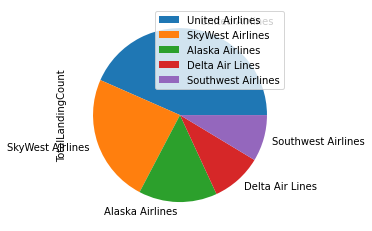

In [71]:
import matplotlib.pyplot as plt

input_data.select('ActivityPeriod', 'OperatingAirline', 'LandingCount')\
        .withColumn('ActivityPeriod', input_data.ActivityPeriod.cast(StringType()))\
        .withColumn('ActivityPeriod', to_date('ActivityPeriod', format='yyyyMM'))\
        .withColumn('ActivityPeriod', year('ActivityPeriod'))\
        .filter('ActivityPeriod > 2015')\
        .groupBy('ActivityPeriod', 'OperatingAirline')\
        .agg(sum('LandingCount').alias('TotalLandingCount'))\
        .withColumn('Rank', dense_rank().over(Window.partitionBy('ActivityPeriod').orderBy(desc('TotalLandingCount'))))\
        .filter('Rank <= 5')\
        .select('ActivityPeriod', 'Rank', 'OperatingAirline', 'TotalLandingCount')\
        .orderBy(['ActivityPeriod', 'Rank'], ascending=[0, 1])\
        .filter('ActivityPeriod = 2019')\
        .select('OperatingAirline', 'TotalLandingCount')\
        .toPandas()\
        .set_index('OperatingAirline')\
        .plot.pie(y='TotalLandingCount')

In [69]:
%matplotlib inline
plt.pie(panda_df['TotalLandingCount'], index=panda_df['OperatingAirline'], autopct='%1.1f%%', counterclock=False, shadow=True)
plt.legend(labels)
plt.show()

TypeError: pie() got an unexpected keyword argument 'index'

c:\users\sudip.a.banerjee\pycharmprojects\learning\venv\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


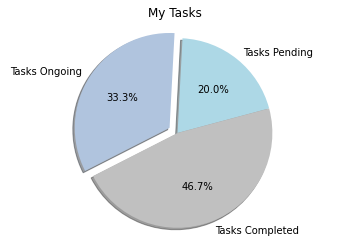

In [46]:
from pandas import DataFrame
import matplotlib.pyplot as plt

%matplotlib inline

Data = {'Tasks': [300,500,700]}
df = DataFrame(Data,columns=['Tasks'])

my_labels = 'Tasks Pending','Tasks Ongoing','Tasks Completed'
my_colors = ['lightblue','lightsteelblue','silver']
my_explode = (0, 0.1, 0)
plt.pie(df, labels=my_labels, autopct='%1.1f%%', startangle=15, shadow = True, colors=my_colors, explode=my_explode)
plt.title('My Tasks')
plt.axis('equal')
plt.show()